# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run114', 'ORACLE.run132', 'ORACLE.run120', 'ORACLE.run144', 'ORACLE.run18', 'ORACLE.run138', 'ORACLE.run150', 'ORACLE.run126'}


{'Wisig_2', 'Wisig_3', 'Wisig_4', 'Wisig_1'}


tensor([[[ 0.2037,  0.1759, -1.2224,  ..., -0.0556,  0.9168, -0.1111],
         [ 0.2500,  0.3612, -0.4075,  ..., -1.0464, -0.5556,  0.1852]],

        [[-0.9323, -1.0511,  0.4022,  ..., -0.9688,  0.1554,  1.1151],
         [-1.0145,  0.4022, -0.7312,  ..., -1.1242, -0.7769, -0.5667]],

        [[ 0.0381, -0.8183,  0.4282,  ...,  0.1808,  0.3901,  0.1522],
         [ 1.3702, -0.5994, -0.0666,  ..., -0.0476, -0.2284, -0.8373]],

        ...,

        [[ 1.1086, -0.6166, -1.0890,  ...,  0.0787, -1.0299, -0.2755],
         [ 0.9774, -0.3477, -0.6101,  ...,  0.9906,  0.6494,  0.2230]],

        [[ 0.7334,  0.0498, -0.1638,  ..., -1.4384, -0.8972, -0.5127],
         [-0.7121,  0.3418, -0.2635,  ...,  0.3133,  0.1638,  0.5839]],

        [[ 0.1154,  1.1802,  0.5195,  ..., -0.4169, -1.6355, -0.6670],
         [ 0.3463, -0.6927, -0.6414,  ..., -0.4554,  0.0192, -0.6927]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.5443, train_label_loss: 2.7717, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3695.0492, train_label_loss: 1.3035, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3785.5903, train_label_loss: 0.9646, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3694.0346, train_label_loss: 0.7006, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3594.7949, train_label_loss: 1.0027, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 4012.0113, train_label_loss: 1.1071, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 5142.1946, train_label_loss: 1.4862, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 4997.0456, train_label_loss: 0.6442, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 4788.3508, train_label_loss: 0.8628, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 4952.9770, train_label_loss: 0.7297, 


epoch: 1, source_val_acc_label: 0.6424, target_val_acc_label: 0.6605, source_val_label_loss: 0.9510, target_val_label_loss: 6.5260, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 1.2824, train_label_loss: 0.9319, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3903.8191, train_label_loss: 0.6807, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3361.4937, train_label_loss: 1.1037, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 2962.0086, train_label_loss: 1.1774, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 2940.3965, train_label_loss: 0.6628, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3003.6148, train_label_loss: 0.8000, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 2966.0102, train_label_loss: 0.7355, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 2960.4064, train_label_loss: 0.5050, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 2967.1964, train_label_loss: 0.5327, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 2964.6277, train_label_loss: 0.6224, 


epoch: 2, source_val_acc_label: 0.6815, target_val_acc_label: 0.6920, source_val_label_loss: 0.8443, target_val_label_loss: 7.5308, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.8071, train_label_loss: 0.5630, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3392.9982, train_label_loss: 1.2426, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3332.9557, train_label_loss: 0.5158, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3021.7209, train_label_loss: 0.9004, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2998.8801, train_label_loss: 0.4177, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 2972.0404, train_label_loss: 1.0498, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 2985.6129, train_label_loss: 1.0578, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 2977.5171, train_label_loss: 0.6694, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 2974.6907, train_label_loss: 0.5028, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3022.0502, train_label_loss: 0.5789, 


epoch: 3, source_val_acc_label: 0.7037, target_val_acc_label: 0.7321, source_val_label_loss: 0.7877, target_val_label_loss: 7.5996, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.8062, train_label_loss: 0.6162, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3460.3447, train_label_loss: 0.5528, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3381.5231, train_label_loss: 0.6650, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3023.5686, train_label_loss: 1.0321, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3012.6971, train_label_loss: 0.9535, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3010.6089, train_label_loss: 0.5555, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 2982.4996, train_label_loss: 0.2253, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 2982.2773, train_label_loss: 0.8651, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 2962.1783, train_label_loss: 0.7713, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3003.4740, train_label_loss: 0.6417, 


epoch: 4, source_val_acc_label: 0.7254, target_val_acc_label: 0.7510, source_val_label_loss: 0.7395, target_val_label_loss: 7.8554, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.7999, train_label_loss: 0.5577, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3407.8301, train_label_loss: 0.3113, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3219.9387, train_label_loss: 0.2452, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3034.5737, train_label_loss: 1.0473, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 2971.5484, train_label_loss: 0.6561, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 2971.1836, train_label_loss: 0.8240, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 2991.3506, train_label_loss: 0.7073, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 2979.6146, train_label_loss: 0.4943, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 2986.6975, train_label_loss: 0.3555, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 2983.2386, train_label_loss: 0.9346, 


epoch: 5, source_val_acc_label: 0.7312, target_val_acc_label: 0.7635, source_val_label_loss: 0.7293, target_val_label_loss: 8.6841, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.7965, train_label_loss: 0.4158, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3475.8053, train_label_loss: 0.4764, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3009.8861, train_label_loss: 0.7904, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 2989.0455, train_label_loss: 1.0855, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 2966.2066, train_label_loss: 0.5566, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 2983.9327, train_label_loss: 0.6476, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 2973.6451, train_label_loss: 0.6647, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 2968.2164, train_label_loss: 0.2455, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3011.8706, train_label_loss: 0.5405, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 2963.4124, train_label_loss: 0.0953, 


epoch: 6, source_val_acc_label: 0.7361, target_val_acc_label: 0.7690, source_val_label_loss: 0.7376, target_val_label_loss: 9.1510, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.8192, train_label_loss: 0.4111, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3289.5798, train_label_loss: 0.4831, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 2942.7936, train_label_loss: 0.8842, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 2954.4505, train_label_loss: 0.5099, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 2941.3189, train_label_loss: 0.6356, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3003.4214, train_label_loss: 0.7274, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 2984.5773, train_label_loss: 0.2998, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 2978.1044, train_label_loss: 0.4490, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3036.1617, train_label_loss: 0.6157, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3010.2081, train_label_loss: 0.8469, 


epoch: 7, source_val_acc_label: 0.7358, target_val_acc_label: 0.7743, source_val_label_loss: 0.7408, target_val_label_loss: 9.2758, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.8399, train_label_loss: 0.6155, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3115.6972, train_label_loss: 0.5243, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 2992.4510, train_label_loss: 0.2110, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 2980.2381, train_label_loss: 0.4514, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 2995.2447, train_label_loss: 0.5136, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 2981.7981, train_label_loss: 0.2296, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 2987.0469, train_label_loss: 0.1885, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 2982.0931, train_label_loss: 0.3408, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3006.9458, train_label_loss: 0.3862, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 2990.6071, train_label_loss: 0.5586, 


epoch: 8, source_val_acc_label: 0.7372, target_val_acc_label: 0.7762, source_val_label_loss: 0.7543, target_val_label_loss: 9.9334, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.8578, train_label_loss: 0.3458, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3011.1503, train_label_loss: 0.3551, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 2985.4696, train_label_loss: 0.5464, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 2991.3261, train_label_loss: 0.2002, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 2997.5891, train_label_loss: 0.5006, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3004.7518, train_label_loss: 0.4333, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3006.9837, train_label_loss: 0.3041, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 2981.0631, train_label_loss: 0.5303, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 2966.6314, train_label_loss: 0.3226, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 2970.7455, train_label_loss: 0.2332, 


epoch: 9, source_val_acc_label: 0.7325, target_val_acc_label: 0.7829, source_val_label_loss: 0.7649, target_val_label_loss: 10.1213, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.8579, train_label_loss: 0.3317, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 2967.9089, train_label_loss: 0.4201, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 2986.0618, train_label_loss: 0.5541, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 2941.6019, train_label_loss: 0.5554, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 2964.9570, train_label_loss: 0.4920, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 2986.4354, train_label_loss: 0.2391, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 2986.1089, train_label_loss: 0.1256, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 2953.5200, train_label_loss: 0.2017, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 2994.0967, train_label_loss: 0.4111, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 2968.1259, train_label_loss: 0.3950, 


epoch: 10, source_val_acc_label: 0.7285, target_val_acc_label: 0.7819, source_val_label_loss: 0.7851, target_val_label_loss: 10.6913, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.8783, train_label_loss: 0.6473, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 2975.3498, train_label_loss: 0.3223, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 2963.6756, train_label_loss: 0.1311, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 2984.5096, train_label_loss: 0.4604, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 2993.6525, train_label_loss: 0.2395, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3006.4308, train_label_loss: 0.0786, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3002.9671, train_label_loss: 0.0565, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3024.2806, train_label_loss: 0.2580, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 2992.9517, train_label_loss: 0.2270, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 2970.7034, train_label_loss: 0.6544, 


epoch: 11, source_val_acc_label: 0.7330, target_val_acc_label: 0.7868, source_val_label_loss: 0.7983, target_val_label_loss: 11.0231, 


New best


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.8789, train_label_loss: 0.3858, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 2996.2057, train_label_loss: 0.3355, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3014.3507, train_label_loss: 0.2195, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3027.8268, train_label_loss: 0.3749, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 2979.2433, train_label_loss: 0.3643, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 2967.1267, train_label_loss: 0.3517, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3014.8312, train_label_loss: 0.1665, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3032.3831, train_label_loss: 0.0924, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 2990.3637, train_label_loss: 0.3262, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3016.5910, train_label_loss: 0.5235, 


epoch: 12, source_val_acc_label: 0.7338, target_val_acc_label: 0.7834, source_val_label_loss: 0.8342, target_val_label_loss: 11.5707, 


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.8701, train_label_loss: 0.1803, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 2997.7937, train_label_loss: 0.6269, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 2986.3090, train_label_loss: 0.5105, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 2994.1934, train_label_loss: 0.1678, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 2985.3436, train_label_loss: 0.2352, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3019.1205, train_label_loss: 0.3478, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3011.6160, train_label_loss: 0.3260, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 2982.3138, train_label_loss: 0.1307, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 2969.2496, train_label_loss: 0.2219, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 2965.0528, train_label_loss: 0.6697, 


epoch: 13, source_val_acc_label: 0.7310, target_val_acc_label: 0.7836, source_val_label_loss: 0.8642, target_val_label_loss: 12.2798, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.8634, train_label_loss: 0.2738, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 2994.4958, train_label_loss: 0.1499, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 3004.2295, train_label_loss: 0.1237, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 2970.7722, train_label_loss: 0.5541, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 2943.6124, train_label_loss: 0.3385, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 2986.1131, train_label_loss: 0.1595, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 3012.9586, train_label_loss: 0.5737, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 3004.8401, train_label_loss: 0.1756, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 2971.9287, train_label_loss: 0.4250, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 2980.4544, train_label_loss: 0.1876, 


epoch: 14, source_val_acc_label: 0.7247, target_val_acc_label: 0.7884, source_val_label_loss: 0.8663, target_val_label_loss: 12.1589, 


New best


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.8716, train_label_loss: 0.1226, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 2989.8073, train_label_loss: 0.3576, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 3019.5980, train_label_loss: 0.1907, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 3032.4340, train_label_loss: 0.3971, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 3008.7835, train_label_loss: 0.4569, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 2985.0931, train_label_loss: 0.4610, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 2963.9219, train_label_loss: 0.0840, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 2986.7284, train_label_loss: 0.1885, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 2989.4426, train_label_loss: 0.0862, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 3026.6396, train_label_loss: 0.1073, 


epoch: 15, source_val_acc_label: 0.7246, target_val_acc_label: 0.7846, source_val_label_loss: 0.9141, target_val_label_loss: 13.1339, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 0.8597, train_label_loss: 0.2392, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3004.8050, train_label_loss: 0.1862, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 2993.2368, train_label_loss: 0.3346, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 3005.3824, train_label_loss: 0.2866, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3009.7973, train_label_loss: 0.0718, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 2980.2044, train_label_loss: 0.1171, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 2987.2991, train_label_loss: 0.2836, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 2979.7854, train_label_loss: 0.1335, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 2998.3024, train_label_loss: 0.1625, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 3000.4865, train_label_loss: 0.4238, 


epoch: 16, source_val_acc_label: 0.7227, target_val_acc_label: 0.7869, source_val_label_loss: 0.9322, target_val_label_loss: 13.2039, 


epoch: 17, [batch: 1 / 33600], examples_per_second: 0.8520, train_label_loss: 0.4384, 


epoch: 17, [batch: 3360 / 33600], examples_per_second: 2974.0719, train_label_loss: 0.2154, 


epoch: 17, [batch: 6720 / 33600], examples_per_second: 3011.7229, train_label_loss: 0.2395, 


epoch: 17, [batch: 10080 / 33600], examples_per_second: 2966.6864, train_label_loss: 0.1718, 


epoch: 17, [batch: 13440 / 33600], examples_per_second: 2940.5143, train_label_loss: 0.1519, 


epoch: 17, [batch: 16800 / 33600], examples_per_second: 2979.8156, train_label_loss: 0.1168, 


epoch: 17, [batch: 20160 / 33600], examples_per_second: 2964.5391, train_label_loss: 0.3885, 


epoch: 17, [batch: 23520 / 33600], examples_per_second: 2976.9746, train_label_loss: 0.3042, 


epoch: 17, [batch: 26880 / 33600], examples_per_second: 2968.6002, train_label_loss: 0.2389, 


epoch: 17, [batch: 30240 / 33600], examples_per_second: 3007.5021, train_label_loss: 0.0866, 


epoch: 17, source_val_acc_label: 0.7217, target_val_acc_label: 0.7873, source_val_label_loss: 0.9452, target_val_label_loss: 13.7367, 


epoch: 18, [batch: 1 / 33600], examples_per_second: 0.8678, train_label_loss: 0.3728, 


epoch: 18, [batch: 3360 / 33600], examples_per_second: 2986.9253, train_label_loss: 0.3212, 


epoch: 18, [batch: 6720 / 33600], examples_per_second: 3007.7163, train_label_loss: 0.0555, 


epoch: 18, [batch: 10080 / 33600], examples_per_second: 3018.9532, train_label_loss: 0.1745, 


epoch: 18, [batch: 13440 / 33600], examples_per_second: 2993.9450, train_label_loss: 0.2904, 


epoch: 18, [batch: 16800 / 33600], examples_per_second: 2989.9998, train_label_loss: 0.2807, 


epoch: 18, [batch: 20160 / 33600], examples_per_second: 2970.8721, train_label_loss: 0.2818, 


epoch: 18, [batch: 23520 / 33600], examples_per_second: 2998.9324, train_label_loss: 0.1073, 


epoch: 18, [batch: 26880 / 33600], examples_per_second: 3006.5321, train_label_loss: 0.3906, 


epoch: 18, [batch: 30240 / 33600], examples_per_second: 3010.7485, train_label_loss: 0.4626, 


epoch: 18, source_val_acc_label: 0.7191, target_val_acc_label: 0.7878, source_val_label_loss: 0.9867, target_val_label_loss: 14.3693, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

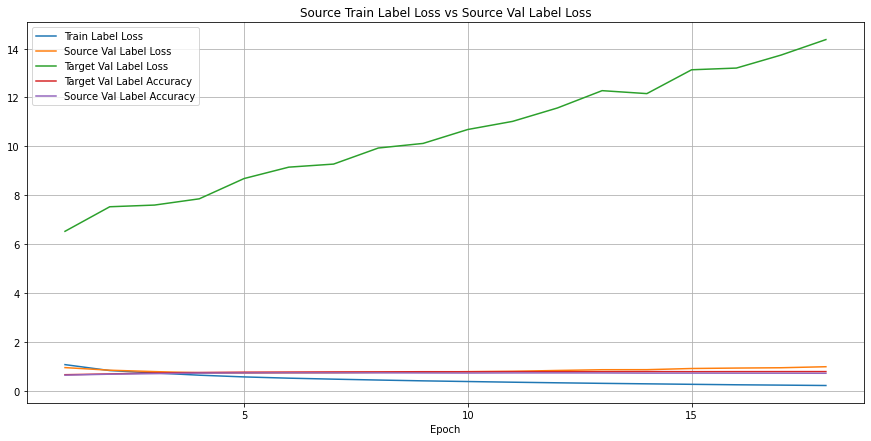

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

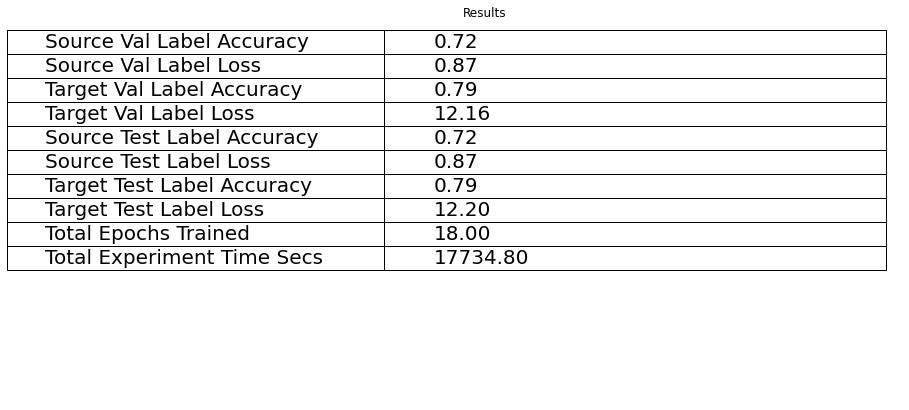

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

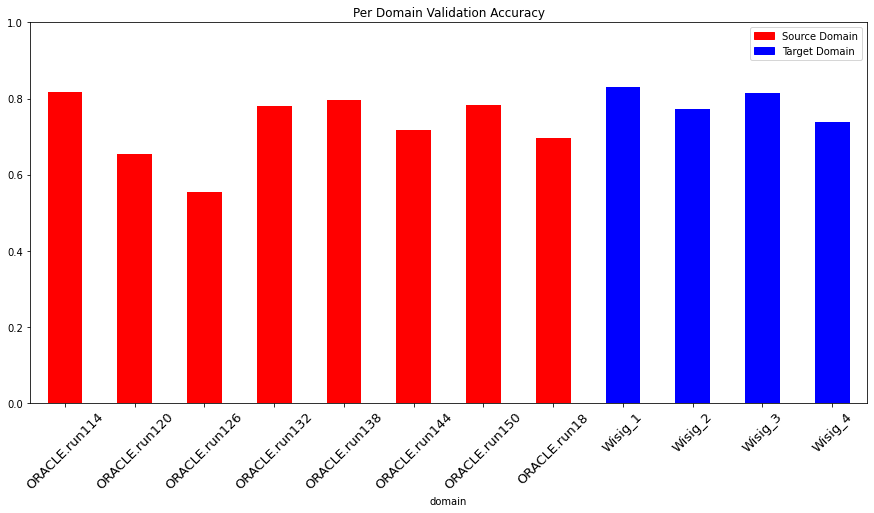

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7232682291666667 Target Test Label Accuracy: 0.7887228260869565
Source Val Label Accuracy: 0.7247200520833333 Target Val Label Accuracy: 0.7884183403805497


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL